In [ ]:
!pip install ipywidgets

<IPython.core.display.Javascript object>

Saved to photo.jpg


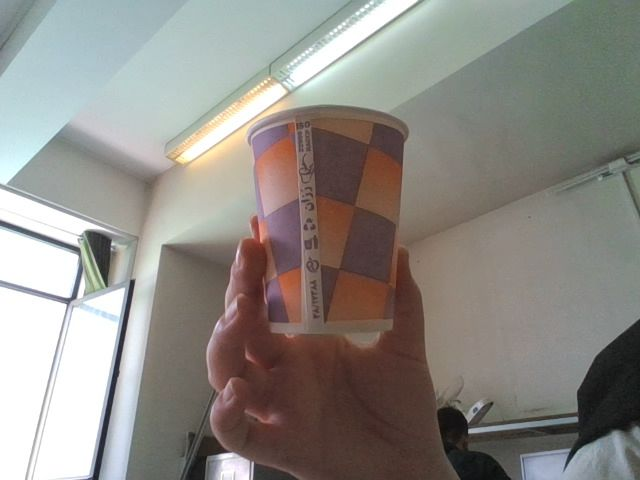

1/1 [==============================] - 2s 2s/step
Top 5 Predictions:
1: cash_machine (0.0523)
2: hand_blower (0.0446)
3: pay-phone (0.0272)
4: hair_spray (0.0254)
5: guillotine (0.0204)


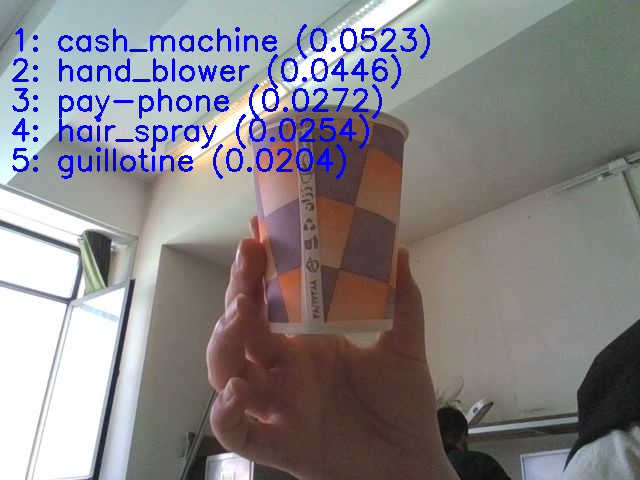

In [ ]:
import tensorflow as tf
from PIL import Image
import cv2
import numpy as np
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import io
import ipywidgets as widgets

# Load pre-trained model (EfficientNetB0 for example)
model = tf.keras.applications.EfficientNetB0(weights='imagenet')

# Function to preprocess image for model
def preprocess_image(image):
    # Resize image to 224x224 pixels, which is the expected input size for EfficientNetB0
    image = cv2.resize(image, (224, 224))
    # Add a batch dimension
    image = np.expand_dims(image, axis=0)
    # Preprocess the image using EfficientNet-specific preprocessing
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image

# JavaScript to take a photo using webcam
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            const dataUrl = canvas.toDataURL('image/jpeg', quality);
            div.remove();
            return dataUrl;
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Function to predict image using the model
def predict_image(image):
    preds = model.predict(image)
    class_names = tf.keras.applications.efficientnet.decode_predictions(preds, top=5)[0]

    print('Top 5 Predictions:')
    for i, (imagenet_id, label, score) in enumerate(class_names):
        print(f'{i+1}: {label} ({score:.4f})')

    return class_names  # Return the top 5 predictions

# Function to display an image with OpenCV using PIL
def display_image(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(image_rgb))

# Function to handle photo capture and prediction
def handle_photo_capture(_):
    try:
        filename = take_photo()
        print('Saved to {}'.format(filename))

        # Display the photo
        img = Image.open(filename)
        display(img)

        # Preprocess the image and make predictions
        img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        preprocessed_image = preprocess_image(img_cv)

        # Predict the image using the model
        predictions = predict_image(preprocessed_image)

        # Display the top 5 prediction labels on the image
        img_with_labels = img_cv.copy()
        for i, (imagenet_id, label, score) in enumerate(predictions):
            cv2.putText(img_with_labels, f'{i+1}: {label} ({score:.4f})',
                        (10, 50 + i * 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

        display_image(img_with_labels)
    except Exception as e:
        print(f"An error occurred: {e}")

# Function to choose image from file
def choose_file(_):
    try:
        file_picker = widgets.FileUpload(accept='image/*', multiple=False)
        display(file_picker)

        def handle_upload(change):
            try:
                img = Image.open(io.BytesIO(file_picker.data[-1]))
                display(img)
                img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
                preprocessed_image = preprocess_image(img_cv)
                predictions = predict_image(preprocessed_image)

                # Display the top 5 prediction labels on the image
                img_with_labels = img_cv.copy()
                for i, (imagenet_id, label, score) in enumerate(predictions):
                    cv2.putText(img_with_labels, f'{i+1}: {label} ({score:.4f})',
                                (10, 50 + i * 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

                display_image(img_with_labels)
            except Exception as e:
                print(f"An error occurred while processing the uploaded file: {e}")

        file_picker.observe(handle_upload, names='data')
    except Exception as e:
        print(f"An error occurred: {e}")

# Create GUI elements
btn_webcam = widgets.Button(description="Take Photo")
btn_webcam.on_click(handle_photo_capture)

btn_file = widgets.Button(description="Choose File")
btn_file.on_click(choose_file)

# Display the buttons
display(widgets.HBox([btn_webcam, btn_file]))


In [ ]:
#    async function takePhoto(quality) {
 #        const div = document.createElement('div'); // ایجاد یک المان div جدید
  #        const capture = document.createElement('button'); // ایجاد یک دکمه جدید
   #       capture.textContent = 'Capture'; // تنظیم متن دکمه به 'Capture'
    #      div.appendChild(capture); // اضافه کردن دکمه به div

     #     const video = document.createElement('video'); // ایجاد یک المان ویدئو جدید
      #    video.style.display = 'block'; // تنظیم نمایش ویدئو به صورت بلاک